# Линейная модель. Градиентный метод

Описание: <a href="http://qudata.com/ml/ru/ML_Line_Regression.html">ML_Line_Regression.html</a>

## Необходимые библиотеки

In [81]:
import numpy as np                                # работа с тензорами
from   numpy.linalg import inv, pinv              # обратные и для не квадратных матриц

import matplotlib.pyplot as plt                   # постороение графиков
from   mpl_toolkits.mplot3d import Axes3D         # 3D - графики

from   tensorflow       import keras              # keras из tensorflow
from   keras.models     import Sequential         # способ формирования слоёв (стопка)
from   keras.layers     import Dense              # полносвязный слой
from   keras.optimizers import SGD                # метод оптимизации

from   time import perf_counter as tm             # время вычисления

import sys, numpy, matplotlib
print("python:    ", sys.version)
print("numpy:     ", numpy.__version__)
print("matplotlib:", matplotlib.__version__)
print("keras:     ", keras.__version__)

np.set_printoptions(precision=3, suppress=True)   # число цифр после точки в print

Using TensorFlow backend.


python:     3.7.6 (tags/v3.7.6:43364a7ae0, Dec 19 2019, 00:42:30) [MSC v.1916 64 bit (AMD64)]
numpy:      1.18.1
matplotlib: 3.2.0
keras:      2.2.4-tf


## Регрессия

Регрессия - это отображение точки вещественного пространства $\mathbb{R}^{n_x}$ в точку вещественного пространства $\mathbb{R}^{n_y}$.
Проще говоря, это многомерная функция $\mathbf{y}=f(\mathbf{x})$, где $\mathbf{x}$ и $\mathbf{y}$ - векторы  с $n_x$ и $n_y$ компонентами соответственно. Ниже создаётся линенейная функция $y=f(x_0,x_1)$:

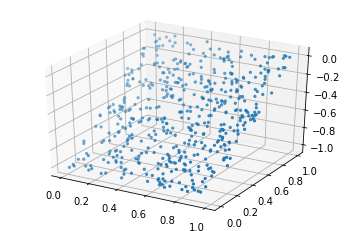

In [82]:
N = 500            # число точек (примеров)
nX  = 2            # число входов (число признаков)
nY  = 1            # число выходов модели

w = np.array([ [0], [1] ])
b = np.array(  [ -1, 1]  )

X = np.random.random ((N, nX))             
Y = np.dot(X, w) + b  + np.random.normal (0, 0.01, (N, nY))

ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y[:,0], s=5)
plt.show()

## Генерация данных для регрессии

In [92]:
N  = 100                      # число точек (примеров)
nX = 2                        # число входов (число признаков)
nY = 3                        # число выходов модели

w = np.array([[  1,  3,  5],
              [  6,  4,  2] ])
b = np.array( [ -3, -2, -1]  )

X = np.random.random ((N, nX))                   # (100,3)

Y = np.dot(X, w) + b 
Y += np.random.normal (0, 0.01, (N, nY))      

print("X:",X.shape," Y:",Y.shape)

X: (100, 2)  Y: (100, 3)


## Аналитическое вычисление параметов модели

In [93]:
XX = np.concatenate( (X, np.ones((N, 1))) , axis=1)         # добавляем столбик единиц

tm1 = tm(); 
W1 = np.dot( inv(np.dot(XX.T, XX)) , np.dot(XX.T, Y) ) 
print("tm1 = %.2f ms" % (1000*(tm()- tm1)) )     # 0.63 ms   

tm2 = tm(); 
W2 = np.dot(pinv(XX), Y)
print("tm2 = %.2f ms" % (1000*(tm()- tm2)) )     # 1.19 ms

print( W1 )                                    
print( W2 )                                    

tm1 = 0.45 ms
tm2 = 0.36 ms
[[ 0.999  3.     5.003]
 [-0.005  0.     0.004]
 [-2.997 -1.999 -1.004]]
[[ 0.999  3.     5.003]
 [-0.005  0.     0.004]
 [-2.997 -1.999 -1.004]]


## Решение на sklearn

In [94]:
from sklearn.linear_model import LinearRegression

tm1 = tm();
lr = LinearRegression().fit(X,Y)
print("tm1 = %.2f ms" % (1000*(tm()- tm1)) )

print(lr.coef_.T)
print(lr.intercept_)

mse =  np.mean((X @ lr.coef_.T + lr.intercept_ - Y) ** 2)
print(f"mse:{mse:.5f}, sqrt(mse):{np.sqrt(mse):.5f} ")

tm1 = 0.92 ms
[[ 0.999  3.     5.003]
 [-0.005  0.     0.004]]
[-2.997 -1.999 -1.004]
mse:0.00010, sqrt(mse):0.01004 


## Численный поиск минимума

In [ ]:
def Loss(X,Y, W, B):
    return np.mean((X @ W + B - Y) ** 2)

def My_SGD(X, Y, lr, mo, batch_size, epochs=1, mode="keras"):

    if mode=="keras":  lr = lr / (1-mo)
    
    W = np.random.random ((nX, nY))                      # случайные начальные значения
    B = np.random.random ((nY, )  )                      # параметров модели

    dW,  dB  = 0, 0
    agW, agB = 0, 0    
    
    losses = [Loss(X,Y, W, B)]                           # начальная ошибка
    iters  = int( len(X)/batch_size )  

    for epoch in range(epochs):                          # эпоха - проход по всем примерам
        
        idx = np.random.permutation( len(X) )            # перемешанный список индексов
        X, Y = X[idx], Y[idx]                            # перемешиваем данные
        
        for i in range(0, iters*batch_size, batch_size): # примеры разбиты на пачки             
            xb = X[i: i+batch_size]                      # входы пачки
            yb = Y[i: i+batch_size]                      # выходы пачки (целевые значения)
        
            y = xb @ W + B                               # выходы модели
        
            gW = (2 / y.size) * xb.T @ (y - yb)          # градиент по w
            gB = (2 / y.size) * np.sum(y - yb, axis=0)   # градиент по b
        
            agW = mo * agW + (1-mo) * gW;    W -= lr * agW
            agB = mo * agB + (1-mo) * gB;    B -= lr * agB
        
        loss = Loss(X,Y, W, B)        
        losses.append( loss )                            # ошибка в конце эпохи
        if loss > 1000:
            break
    return losses, W, B

batch_size = 10
mo, lr    = 0, 0.1 

tm1 = tm() 
leg = []
for lr in [0.01, 0.1, 1, 1.5]:
    losses,W,B = My_SGD(X,Y, lr, mo, batch_size, epochs=50)
    print(" %.1f ms" % ( (tm()-tm1)*1000) )
    print("loss: %.5f"  % ( losses[-1] ))

    plt.plot(losses, marker=".")
    leg.append( f"lr:{lr:.2f}  loss:{losses[-1]:.4f}"  )
plt.legend(leg)
plt.show()
        
print(W)
print(B)

## Подбор оптимальных гиперпараметров

In [ ]:
epochs     = 2                    # число эпох минимизации
lr         = 2.5                 # скорость обучения (lambda)
mo         = 0.8                 # момент (beta)
batch_size = 20                  # число примеров в пачке
 
# диапазон изменения гиперпараметров:    
parX_min, parX_max, parX_num = 0.001, 10,   50    # lr
#parX_min, parX_max, parX_num = 3, 3,   1    # lr
parY_min, parY_max, parY_num = 0,   0.999,  20   # mo

#parY_min, parY_max, parY_num = 1, 50,    20    # batch_size

parX_arr = np.linspace(parX_min, parX_max, parX_num)  # табулируем гиперпараметры
parY_arr = np.linspace(parY_max, parY_min, parY_num)  

def plot_losses(mode):
    """Табулируем ошибку при различных гиперпараметрах mo и lr"""
    res = np.array([])
    for parY in parY_arr:           # для всех гиперпараметров
        for parX in parX_arr:       # вычисляем ошибку по epochs (обрезаем расходимости)
            lr = parX
            mo = parY
            batch_size = 32 
            losses, _, _ = My_SGD(X, Y, lr, mo, batch_size, epochs=epochs, mode=mode)
            res = np.append(res, losses[-1] if losses[-1] < 5 else 5)
    
    res = res.reshape( (parY_num, parX_num ))  # делаем прямоугольную матрицу (картинку)

    plt.figure(figsize=(16, 2))                            # выводим массив ошибок как картинку    
    plt.imshow(res, 
               interpolation='nearest', cmap=plt.cm.PuOr_r,
               aspect='auto',
               extent=(parX_min, parX_max, parY_min, parY_max))            # ось y - вверх

    # линия минимальной ошибки при данном значении lr:
    plt.plot(parX_arr,   parY_arr[ np.argmin(res, axis=0) ], marker="." )    
    #plt.xticks(np.arange(parX_min, parX_max+0.1, step=0.5)) 
    #plt.yticks(np.arange(parY_min, parY_max+0.1, step=0.2))
    plt.xlabel('lr');  plt.ylabel('mo');
    #plt.grid(True) 
    #plt.colorbar()

    plt.figure(figsize=(16, 2))                              # график ошибки
    plt.xlim(parX_min, parX_max); plt.ylim(0, 0.02);
    plt.xlabel('lr');    plt.ylabel('loss')    
    plt.xticks(np.arange(parX_min, parX_max+0.1, step=0.5)) 
    plt.plot(parX_arr,  np.min(res, axis=0))
    plt.show()
    
    print("loss_min = %.6f " % ( np.min(res)) )                # минимум ошибки
    parY_best = parY_arr[int(np.argmin(res) / parX_arr.size)]  # гиперпараметры в минимуме
    parX_best = parX_arr[int(np.argmin(res) % parX_arr.size)]
    lr = parX_best;  mo = parY_best
    losses, _, _ = My_SGD(X, Y, lr, mo, batch_size, epochs=epochs, mode=mode)
    print("mo=%.3f, lr=%.3f, loss=%.6f" % ( mo, lr, losses[-1]) )
    

plot_losses("")    
#plot_losses("keras")

In [ ]:
bs= 1 loss_min = 0.068193  mo=0.631, lr=6.735, loss=0.196707
bs= 5 loss_min = 0.058376  mo=0.578, lr=5.919, loss=0.116869
bs=10 loss_min = 0.071338  mo=0.684, lr=8.776, loss=0.392669
bs=15 loss_min = 0.088431  mo=0.789, lr=9.388, loss=0.387997
bs=20 loss_min = 0.081932  mo=0.789, lr=9.796, loss=0.084562

bs= 1 loss_min = 0.449673  mo=0.526, lr=3.000, loss=0.617203
bs= 5 loss_min = 0.410583  mo=0.421, lr=3.000, loss=0.507869
bs=10 loss_min = 0.420808  mo=0.368, lr=3.000, loss=0.536327
bs=15 loss_min = 0.387842  mo=0.315, lr=3.000, loss=0.862548
bs=20 loss_min = 0.493613  mo=0.526, lr=3.000, loss=0.578988

## Решение на Keras

In [ ]:
model = Sequential()                                          # линейная стопка слоёв

model.add(Dense(units=nY, input_dim=nX)) 

model.summary()                                               # описание слоёв

In [ ]:
model.compile(optimizer = SGD(lr=lr, momentum=mo), loss = 'mse') 

tm2 = tm()
res = model.fit(X, Y, batch_size=batch_size, epochs=10,  verbose=0 ) # , validation_split=0.25  )
print(" %.1f ms" % ( (tm()-tm2)*1000) )

plt.plot(res.history['loss'], marker=".")
plt.legend(["loss: %.5f"  % ( res.history['loss'][-1] )])
plt.show()

for lr in model.layers:  
    w = lr.get_weights()[0]                  # веса
    b = lr.get_weights()[1]                  # смещения
    print(w)
    print(b)

## Градиентный метод на tourch 

In [ ]:
import torch

def grad_tourch(X, Y, lr=1, batch_size=10, epochs=10):
    W = torch.randn(nX, nY, dtype=torch.float64,  requires_grad=True)
    B = torch.randn(nY,     dtype=torch.float64,  requires_grad=True)

    for epoch in range(epochs):                          # эпоха - проход по всем примерам
        
        idx = torch.randperm( len(X) )                   # перемешанный список индексов
        X, Y = X[idx], Y[idx]                            # мешаем данные
        
        sumL, iters = 0, int( len(X)/batch_size)         # суммарная ошибка и число батчей 
        
        for i in range(0, iters*batch_size, batch_size): # примеры разбиты на пачки 
         
            xb = torch.from_numpy(X[i: i+batch_size])
            yb = torch.from_numpy(Y[i: i+batch_size])
            
            y = xb.mm(W).add(B)                          # модель y = bx * W + B
            loss = ((y-yb)**2).mean()                    # mse ошибка по батчу
            sumL += loss.data.item()

            loss.backward()                              # вычисление градиентов
                                                
            with torch.no_grad():   
                W.add_(- lr *  W.grad)                   # без перестраивания графа
                B.add_(- lr *  B.grad)            
            
            W.grad.zero_()                               # обнуляем градиенты
            B.grad.zero_()                               
            
        print(f"{epoch:3d}({iters})  loss:{sumL/iters:0.5f}")

    return W, B

grad_tourch(X, Y)


## Сеть на torch

In [ ]:
import torch.nn as nn

model = nn.Sequential( 
    nn.Linear(nX, nY) 
)
print(model)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
criterion = nn.MSELoss()

In [ ]:
def fit(X,Y, batch_size=50, epochs=20):
    for epoch in range(epochs):                          # эпоха - проход по всем примерам:
        for i in range(0, X.shape[0], batch_size):       # примеры разбиты на пачки 
            bx = torch.Tensor( X[i: i+batch_size] )
            by = torch.Tensor( Y[i: i+batch_size] )
        
            optimizer.zero_grad()                        # обнуляем градиенты
            y = model(bx)                                # прямое распространение            
            loss = criterion(y, by)                      # вычисляем ошибку
            loss.backward()                              # вычисляем градиенты
            optimizer.step()                             # подправляем параметры
                
        if epoch % 2 == 0:
            print('epoch: %d  Loss: %.6f'  % (epoch,  loss.item()))
                
fit(X,Y)

In [ ]:
print(model[0].weight)                                      # веса синапсов
print(model[0].bias)                                        # смещения нейронов

In [ ]:
plt.figure(figsize=(15,4)) 
N = 1000
X = np.zeros((N,))
A1, A2 = np.zeros((N,)),np.zeros((N,))
b1, b2 = 0.8, 0.95
for i in range(1,N):
    X[i] = X[i-1] + 0.1*np.random.normal (0, 1)
    A1[i] = b1*A1[i-1] + (1-b1)*X[i]
    A2[i] = b2*A2[i-1] + (1-b2)*X[i]
plt.plot(X)
plt.plot(A1)
plt.plot(A2)
plt.legend(['data', r'$\beta=0.8$', r'$\beta=0.95$'])    
plt.show()

In [ ]:
ax = plt.figure().add_subplot(1, 1, 1)
x = np.linspace(-5,5, 100)
plt.plot(x,1/(1+np.exp(-x)), linewidth=3)
plt.plot(x,0.5*(1+(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))), linewidth=3)
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.ylim(0, 1)
plt.legend(['sigmoid', '(1+tanh(x))/2'])

In [ ]:
x=[1, 3, 5, -3]
y = np.exp(x)
y /= y.sum()                 # [0.016 0.117 0.867 0.   ]

# Классификация 

Классификация  - это отображение точки пространства признаков $\mathbf{x}$ (вектор с $n_x$ компонентами) в одно из $n_y$ целых чисел $y=\{0,1,...,n_y-1\}$  - номера классов.
Обычно классы не упорядочены и номера им присваиваются в произвольном порядке. Ниже создаётся три кластера,
каждый из которых принадлежит своему классу

## Генерация данных

In [ ]:
nx, ny, N = 2, 3, 300                                 # признаков, классов, точек
X = np.random.normal (0, 0.4, (N,nx))                 # облако 300 точек на плоскости
C = np.zeros(N)                                       # номера правильныъ классов
Y = np.full((N,ny), -1)                               # 300x3 из выходов, заполненных -1

X0 = [[-1,1], [1,1], [0,-1]]                          # центры кластеров
nc = int(N/ny)                                        # примеров каждого класса
for i, x0 in enumerate(X0): 
    C[i*nc:(i+1)*nc] = i                              # номер i-го класса
    Y[i*nc:(i+1)*nc, i] = 1                           # gправильный выход
    X[i*nc:(i+1)*nc]  += np.array(x0)                 # сдвигаем кластер i-го класса
    
fig,ax = plt.subplots(figsize=(5, 5))     # размеры картинки (квадрат)            
plt.scatter(X[:,0], X[:,1], c=C, s=30)
plt.show()

In [ ]:
class Model:
    def __init__(self):
        "Конструктор"
        self.lr = LinearRegression()
        
    def __call__(self, x):
        "Функциональный вызов объекта"
        y = x @ self.lr.coef_.T + self.lr.intercept_
        return np.argmax(y, axis=1)
    
    def fit(self, x,y):
        "Обучение по примерам x,y"
        self.lr.fit(x,y)
        
    def plot(self, x1_min=0, x1_max=1, x2_min=0, x2_max=1, n=201):
        # сетка точек 201 x 201 в интервале x1,x2=[xMin,xMax]
        x1,x2 = np.meshgrid(np.linspace(x1_min, x1_max, n),
                            np.linspace(x2_min, x2_max, n))
        grid  = np.c_[x1.ravel(), x2.ravel()]     # shape = (n*n, 2)        
            
        yp = self(grid).reshape(x1.shape)         # (n*n, ) -> (n, n)
        
        fig,ax = plt.subplots(figsize=(5, 5))     # размеры картинки (квадрат)        
        plt.axis([x1_min,x1_max, x2_min,x2_max])  # диапазон изменения осей    
        
        plt.imshow(yp, interpolation='nearest',   # цвет. карту для 2D массива yp
                  extent=(x1.min(), x1.max(), x2.min(), x2.max()),
                  aspect='auto', origin='lower', alpha=0.2,
                  vmin=0, vmax=yp.max())        

In [ ]:
from sklearn.linear_model import LinearRegression

model = Model()       # экземпляр модели
model.fit(X,Y)        # обучаем
y = model(X)          # поучаем номера классов
(y==C).mean()         # сравниваем с точными (аккуратность)

In [ ]:
model.plot(-2, 2,  -2, 2)
plt.scatter(X[:,0], X[:,1], c=C, s=30, edgecolors='black')
plt.show()

# Оптимальные гиперпараметры на Torch

In [75]:
import numpy as np       
import matplotlib.pyplot as plt                   # постороение графиков
np.set_printoptions(precision=3, suppress=True)   # число цифр после точки в print

import torch
import torch.nn as nn

def get_data(N, nX, nY):
    """Генерим случайные данные"""
    w = np.random.random ((nX, nY)).astype(np.float32)   # случайные значения
    b = np.random.random ((nY, )  ).astype(np.float32)  # для генерации данных
    
    X = np.random.random ((N, nX) ).astype(np.float32)  
    Y = np.dot(X, w) + b + np.random.normal (0, 0.1, (N, nY) ).astype(np.float32)
    return X,Y

def calc_loss(X,Y,  batch_size=10, mo=0, lr=1, epochs=10):
    """Подбираем параметры и возвращаем ошибку"""
    nX, nY, iters = X.shape[1], Y.shape[1], int( len(X)/batch_size )

    model = nn.Sequential( nn.Linear(nX, nY) )

    optimizer = torch.optim.SGD(model.parameters(), lr=lr*(1-mo), momentum=mo)
    criterion = nn.MSELoss()
    
    sumL = 0
    for epoch in range(epochs):                         
        idx = np.random.permutation( len(X) )            # перемешанный список индексов
        X, Y = X[idx], Y[idx]                            # перемешиваем данные (все попадут)        
        
        for i in range(0, iters*batch_size, batch_size):  
            xb = torch.from_numpy( X[i: i+batch_size] )
            yb = torch.from_numpy( Y[i: i+batch_size] )
                    
            y = model(xb)                                # прямое распространение                        
            
            loss = criterion(y, yb)                      # вычисляем ошибку
            loss.backward()                              # вычисляем градиенты
                       
            optimizer.step()                             # подправляем параметры
            optimizer.zero_grad()                        # обнуляем градиенты            
                        
            if loss.item() > 100:
                return 100
            sumL += loss.item()            

    return sumL/(epochs*iters)

ar_bs = np.array([5, 10, 15, 20, 25])
#ar_bs = np.array([10])
ar_mo = np.linspace(0, 0.99, 20)
ar_lr = np.linspace(0.01, 10, 50)

err = np.zeros( (len(ar_bs), len(ar_mo), len(ar_lr)) )

expers = 1
for ex in range(expers):
    print(ex)
    X,Y = get_data(100, 2, 3)    
    
    for i, bs in enumerate(ar_bs):
        for j, mo in enumerate(ar_mo):
            for k, lr in enumerate(ar_lr):                
                err[i,j,k] += calc_loss(X,Y, batch_size=bs, mo=mo, lr=lr)
err /= expers            

0


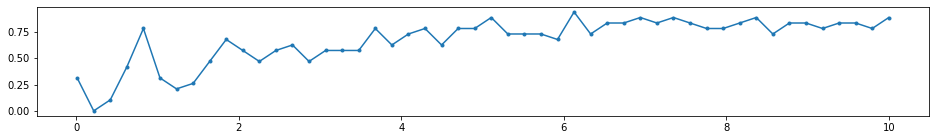

In [78]:
err1= np.min(err, axis=0)
#err1= err[1]
plt.figure(figsize=(16, 2))  
plt.plot(ar_lr, ar_mo[np.argmin(err1, axis=0)], marker=".")
#plt.ylim(0, 1);
plt.show()

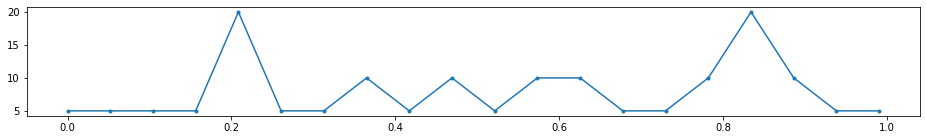

In [80]:
err1= np.min(err, axis=2)
#err1= err[1]
plt.figure(figsize=(16, 2))  
plt.plot(ar_mo, ar_bs[np.argmin(err1, axis=0)], marker=".")
#plt.ylim(0, 1);
plt.show()

In [70]:
a = np.array([[2,  1, 1],
              [0,  5, 6],
              [1, 0, 5]])
np.argmin(a, axis=0)

array([1, 2, 0], dtype=int64)

In [47]:
np.argmin(err[0,:,:], axis=0)

array([8, 2, 6, 5, 7, 7, 7, 7, 8, 8], dtype=int64)

In [ ]:
X,Y = get_data(100, 2, 3)  
print(X.shape, Y.shape)
print(  calc_loss(X,Y, batch_size=10, mo=0, lr=1) )
